In [1]:
import signac
import numpy as np
import matplotlib.pyplot as plt
import freud
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd

In [34]:
project = signac.get_project("workspace")
for job in project:
    print(job)

fe36ee4052a01cae041ef5988477de10


In [58]:
dens = 0.9
temp = 1.7
#if molecule >= "PTB7_5mer_smiles":
#    mer = 5
#elif molecule >= "PTB7_10mer_smiles":
#    mer = 10
#elif molecule >= "PTB7_15mer_smiles":
#    mer = 15
    
state_dict = {"molecule": "PTB7_10mer_smiles", "size":"medium", "process":"quench", "density": dens, "kT_reduced": temp}


job_list = project.find_jobs(state_dict)


In [59]:
for job in job_list:
    rdf_path = job.fn("trajectory.gsd")

In [60]:
def atom_type_pos(frame, atom_types): 
    positions = []
    for idx, type_id in enumerate(frame.particles.typeid):
        if frame.particles.types[type_id] in atom_types:
            positions.append(frame.particles.position[idx])
    return positions

In [61]:
def create_rdf(rdf_path,
               atom_types='all',
               r_max = None,
               r_min = 0.1,
               nbins = 50,
               start = 100):
    
    
    f = gsd.pygsd.GSDFile(open(rdf_path, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f) 
    if r_max is None:
        r_max = max(trajectory[-1].configuration.box[:3]) * 0.45 
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    for frame in trajectory[start:]:
        if atom_types == 'all':
            freud_rdf.compute(system=frame, reset=False)
        else:
            query_points = atom_type_pos(frame, atom_types)
            box = frame.configuration.box
            freud_rdf.compute(system=(box, query_points), reset = False)
        
 
    x = freud_rdf.bin_centers
    y = freud_rdf.rdf
    filename = '{}-trajectory.txt'.format(atom_types[0])
    np.savetxt(job.fn(filename), np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
    f.close()
    return freud_rdf, filename


In [62]:
for job in job_list:
    rdf_path = job.fn("trajectory.gsd")
    #print (rdf_path)
    freud_rdf, filename = create_rdf(rdf_path, atom_types=['f'], start = 95)
    txt_path = job.fn(filename)
    #print(txt_path)

In [73]:
def rdf_plot(job_list): 

    line = np.genfromtxt(txt_path, names = True, delimiter = ",") 

    x = line["bin_centers"]
    y = line["rdf"]
    

    plt.plot(x, y, color = '#ffc08a')

    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.ylim(0, 1.6)
    plt.title("RDF of %s density at %skT of PTB7" % (dens, temp))

    ymax = max(y)
    n_max = y.argmax()
    plt.plot(x[n_max],y[n_max],'o')
    n_min = y.argmin() 
    plt.plot(x[n_min],y[n_min],'x')

    #other notebook in notebook tuts(maybe?) has command to limit decimal places
    plt.annotate("local max {}".format(y[n_max]), xy=(x[n_max],y[n_max]), xytext=(x[n_max]+15,y[n_max]+15), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

    #working on this still
    
    print("max is:") 
    maxvar = ((x[n_max],y[n_max]))
    print("%10.5e"% "maxvar)

    plt.show()
    
    
    
    
    
    
    #this if for a local min vvv
    #plt.annotate('local min', xy=(x[n_min],y[n_min]), xytext=(x[n_min]+15,y[n_min]+15), textcoords='offset points' , arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))
    #print("min of", temp,"kT is:") 
    #print((x[n_min],y[n_min]), sep=",")

max is:


TypeError: must be real number, not str

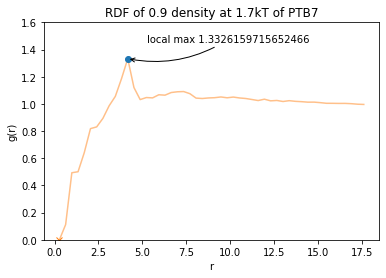

In [74]:
rdf_plot(job_list)